<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S6/EncDec_LSTM_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialising libraries and setting up

In [2]:
! git clone https://github.com/namanphy/END2.git

Cloning into 'END2'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 286 (delta 129), reused 205 (delta 74), pack-reused 0
Receiving objects: 100% (286/286), 7.94 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [3]:
! pip install --upgrade wandb --quiet  # Experiment tracking
! pip install OmegaConf --quiet  # Trying this out for configuration
! pip install tweet-preprocessor --quiet  # Will be used for pre-processing

     |████████████████████████████████| 1.8MB 6.7MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 174kB 26.8MB/s 
     |████████████████████████████████| 133kB 27.4MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 112kB 16.0MB/s 
     |████████████████████████████████| 645kB 39.9MB/s 


In [4]:
cd /content/END2/S6

/content/END2/S6


In [5]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Dataset Preparation
import torchtext
from torchtext.legacy import data 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset # , DataLoader, random_split

#Trainer
from trainer.loss import cross_entropy_loss
from trainer.optimizer import adam_optimizer
from trainer.train import train as Trainer

# Utils
import wandb
from omegaconf import OmegaConf

print("Torchtext version - ", torchtext.__version__)

Torchtext version -  0.9.1


In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Making tweets dataset

**Make sure you have the clean tweets dataset - (csv file) and store it in colab runtime.**

File download - [link](https://github.com/namanphy/END2/blob/main/S6/tweets_clean.csv)

## Loading cleaned dataset

In [9]:
df = pd.read_csv('/content/END2/S6/tweets_clean.csv')
df = df[~df['tweets_clean'].isna()].reset_index(drop=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(5)

,tweets,labels,tweets_clean
0,Obama has called the GOP budget social Darwini...,1,Obama has called the GOP budget social Darwini...
1,"In his teen years, Obama has been known to use...",0,"In his teen years, Obama has been known to use..."
2,IPA Congratulates President Barack Obama for L...,0,IPA Congratulates President Barack Obama for L...
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0,- his connection to supporters of Critical Ra...
4,RT @wardollarshome: Obama has approved more ta...,1,Obama has approved more targeted assassinatio...


## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [10]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [11]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [12]:
fields = [('texts', Tweet),('labels',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [13]:
example = [data.Example.fromlist([df.tweets_clean[i],df.labels[i]], fields) for i in range(df.shape[0])]

In [14]:
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)
twitterDataset = data.Dataset(example, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [15]:
(train, valid) = twitterDataset.split(split_ratio=[0.80, 0.20], random_state=random.seed(SEED))

In [16]:
(len(train), len(valid))

(1081, 270)

An example from the dataset:

In [17]:
print(vars(train.examples[22]))

{'texts': ['the', 'secret', 'handshake', '.', 'Obama', 'is', 'really', 'mad', 'he', 'wants', 'to', 'know', 'this', 'handshake'], 'labels': 0}


## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [18]:
Tweet.build_vocab(train)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [19]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  3452
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 957), ('.', 727), (',', 586), ('"', 524), ('the', 501), (' ', 483), ('?', 403), ('to', 374), ("'s", 288), ('of', 234)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


**Lots of stopwords!!** **But we still had removed non-essential words** see - [tweets_dataset_torchtext_0.9.ipynb](https://github.com/namanphy/END2/blob/main/S6/tweets_dataset_torchtext_0.9.ipynb)

In [20]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

# Setting up Config

In [21]:
hparams = OmegaConf.create({
    'epochs':10,
    'batch_size':32,
    'learning_rate':0.0001,
    'input_dim':len(Tweet.vocab),
    'embedding_dim':100,
    'enc_hidden_dim':50,
    'dec_hidden_dim':50,
    'output_dim': 3,
    'dropout': 0.3,
})

In [ ]:
wandb.init(project='tweet-classification-EncDec')

In [23]:
config = wandb.config
config = hparams
config

{'epochs': 10, 'batch_size': 32, 'learning_rate': 0.0001, 'input_dim': 3452, 'embedding_dim': 100, 'enc_hidden_dim': 50, 'dec_hidden_dim': 50, 'output_dim': 3, 'dropout': 0.3}

# Dataloaders - Bucket Iterator

In [102]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = hparams.batch_size, 
                                                            sort_key = lambda x: len(x.texts),
                                                            sort_within_batch=True, device = device)

In [103]:
item = next(iter(train_iterator))
print(item.texts[0].shape)
print(item.texts[1].shape)

torch.Size([32, 10])
torch.Size([32])


# Defining Our Model

In [104]:
def one(abaa):
    abaa.append(1)
    return 2

aaab = []
print(one(aaab))
print(aaab)

2
[1]


In [105]:
class lstm_encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, dropout=0.1):
        super(lstm_encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)  # [BS, S, Embed]
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=1, dropout=dropout, batch_first=True)

    def forward(self, input, hidden_state, show_states=False):
        encoder_states_collector = []
        (hidden, cell) = hidden_state

        embedded_input = self.embedding(input)  # input= [BS, S] | output= [BS, S, Embed]
        embedded_input = embedded_input.view(input.size()[1], input.size()[0], -1)  # output= [S, BS, Embed]

        # looping seq length times for a batch
        for ix in range(input.size()[1]):  
            output, (hidden, cell) = self.lstm(embedded_input[ix].unsqueeze(1),   # input= [BS, 1, Embed]
                                               (hidden, cell))                    # hidden,cell= [1, BS, Hidden]

            if show_states:
                encoder_states_collector.append({'output': output,
                                                 'hidden': hidden,
                                                 'cell': cell})
        return output, (hidden, cell), encoder_states_collector

    def init_hidden_state(self, batch_size, hidden_dim, device=device):
        zeros = torch.zeros(1, batch_size, hidden_dim).to(device) # 
        return (zeros, zeros)

In [106]:
class lstm_decoder(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(lstm_decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, dropout=dropout, batch_first=True)

    def forward(self, input, hidden_state, steps=3, show_states=False):
        decoder_states_collector = []
        (hidden, cell) = hidden_state

        for i in range(steps):
            decoder_output, (hidden, cell) = self.lstm(input,               # input= [BS, 1, Hidden]
                                                       (hidden, cell))      # hidden,cell= [1, BS, Hidden]
            input = decoder_output

            if show_states:
                decoder_states_collector.append({'output': decoder_output,
                                                 'hidden': hidden,
                                                 'cell': cell})

        return decoder_output, (hidden, cell), decoder_states_collector

    def get_decoder_input(self, batch_size, hidden_dim, device=device):
        return torch.zeros(batch_size, 1, hidden_dim).to(device)


In [107]:
class classifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, batch_size, n_layers, dropout):        
        super(classifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim

        self.encoder = lstm_encoder(vocab_size, embedding_dim, hidden_dim, n_layers, dropout)
        self.decoder = lstm_decoder(hidden_dim, hidden_dim, dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths, decoder_steps=3, show_states=False, states_collector=None):
        if show_states and (states_collector is None):
            print('states_collector cannot be empty if `show_states==True` : Provide an empty dict for collector')

        (encoder_hidden, encoder_cell) = self.encoder.init_hidden_state(text.size()[0], self.hidden_dim) 
        encoder_output, (encoder_hidden, encoder_cell), encoder_states_collector = self.encoder(text,
                                                                                                (encoder_hidden, encoder_cell),
                                                                                                show_states)

        decoder_first_input = self.decoder.get_decoder_input(encoder_hidden.size()[1], self.hidden_dim)
        decoder_output, (decoder_hidden, decoder_cell), decoder_states_collector = self.decoder(decoder_first_input,
                                                                                                (encoder_hidden, encoder_cell),
                                                                                                decoder_steps,
                                                                                                show_states)
        if show_states:
            states_collector['encoder'] = encoder_states_collector
            states_collector['decoder'] = decoder_states_collector

        final_outputs = self.fc(decoder_hidden)
        return final_outputs
    

In [108]:
config

{'epochs': 10, 'batch_size': 32, 'learning_rate': 0.0001, 'input_dim': 3452, 'embedding_dim': 100, 'enc_hidden_dim': 50, 'dec_hidden_dim': 50, 'output_dim': 3, 'dropout': 0.3}

In [109]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = classifier(hparams.input_dim, hparams.embedding_dim, hparams.enc_hidden_dim, hparams.output_dim, 
                   hparams.batch_size, 1, hparams.dropout)

print(model)    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (encoder): lstm_encoder(
    (embedding): Embedding(3452, 100)
    (lstm): LSTM(100, 50, batch_first=True, dropout=0.3)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(50, 50, batch_first=True, dropout=0.3)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
The model has 396,153 trainable parameters


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Model Training and Evaluation

In [110]:
# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

optimizer = adam_optimizer(model, lr=hparams.learning_rate)  # TODO: lr=0.001
criterion = cross_entropy_loss()

model = model.to(device)

In [111]:
# Watching model - WandB

wandb.watch(model, criterion, log='all', log_freq=10)

In [112]:
train_losses, test_losses, train_accuracies, test_accuracies = Trainer(model, 
                                                                     train_iterator, 
                                                                     valid_iterator, 
                                                                     optimizer, 
                                                                     criterion,
                                                                     binary_accuracy,
                                                                     epochs=hparams.epochs)

True
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.045 | Train Acc: 67.81%
	 Val. Loss: 1.023 |  Val. Acc: 71.18% 

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.020 | Train Acc: 67.81%
	 Val. Loss: 0.993 |  Val. Acc: 71.18% 

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.993 | Train Acc: 67.81%
	 Val. Loss: 0.949 |  Val. Acc: 71.18% 

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.956 | Train Acc: 67.81%
	 Val. Loss: 0.890 |  Val. Acc: 71.18% 

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.906 | Train Acc: 67.81%
	 Val. Loss: 0.816 |  Val. Acc: 71.18% 

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.848 | Train Acc: 67.81%
	 Val. Loss: 0.757 |  Val. Acc: 71.18% 

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.810 | Train Acc: 67.81%
	 Val. Loss: 0.734 |  Val. Acc: 71.18% 

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.800 | Train Acc: 67.81%
	 Val. Loss: 0.728 |  Val. Acc: 71.18% 

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.795 | Train Acc: 67.81%
	 Val. Loss: 0.723 |  Val. Acc: 71.18% 

Epoch

In [ ]:
# logging Metrics at WandB

assert len(train_losses) == len(train_accuracies) == len(test_losses) == len(test_accuracies)
for a,b,c,d in list(zip(train_losses, test_losses, train_accuracies, test_accuracies)):
    wandb.log({
        'train loss': a,
        'train acc': c*100,
        'val loss': b,
        'val acc': d*100
    })

# Testing and Diagnosing Model

In [113]:
valid_iterator = iter(valid_iterator)

In [126]:
sample_batch = next(valid_iterator)

In [127]:
sample_batch


[torchtext.legacy.data.batch.Batch of size 32]
	[.texts]:('[torch.cuda.LongTensor of size 32x14 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.labels]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [165]:
states_collector = {}
def diagnose(model, batch):
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    texts, texts_lengths = batch.texts

    text = texts[0].unsqueeze(0)
    texts_length = texts_lengths[0].unsqueeze(0)

    sentence = ' '.join([Tweet.vocab.itos[w] for w in text[0]])
    labels = batch.labels[0].unsqueeze(0)

    with torch.no_grad():
        logits = model(text, texts_length, show_states=True, states_collector=states_collector)

    pred = torch.argmax(logits.squeeze(0), dim=1)
    print('Sentence : ', sentence.strip())
    print('\t Actual output  : ', categories[labels.item()])
    print('\t Result         : ', categories[pred.item()])

diagnose(model, sample_batch)

Sentence :  Blueprints on how conservatives destroy Obama 's lame attempts to launch hashtags .
	 Actual output  :  Negative
	 Result         :  Negative


## Visualising Hidden states - Encoder and Decoder

In [205]:
states_collector.keys()

dict_keys(['encoder', 'decoder'])

In [207]:
print(type(states_collector['encoder']))
states_collector['encoder'][0].keys()

<class 'list'>


dict_keys(['output', 'hidden', 'cell'])

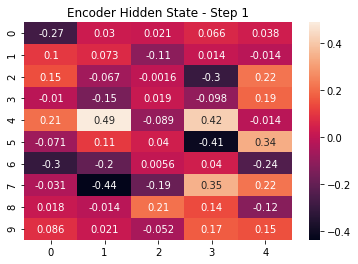

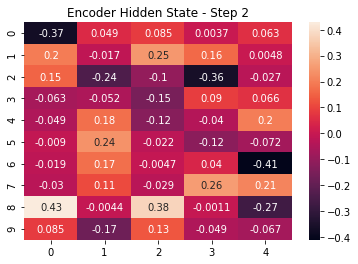

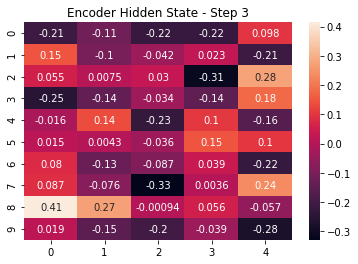

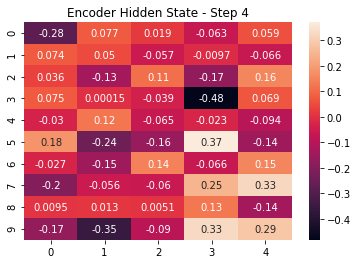

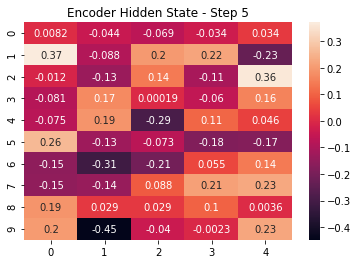

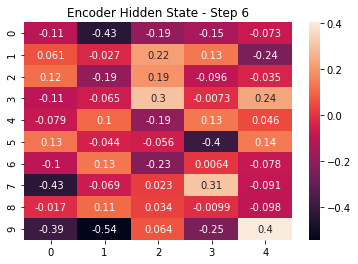

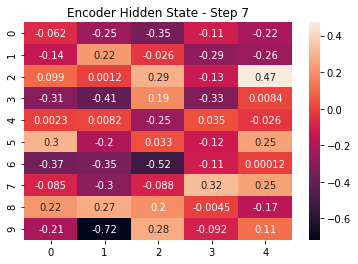

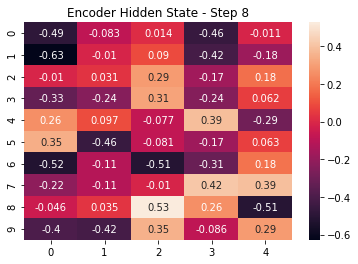

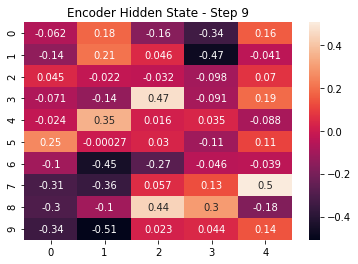

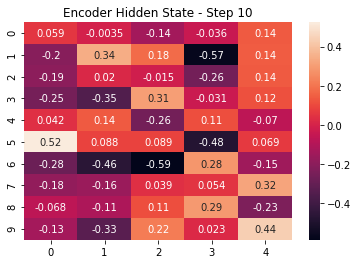

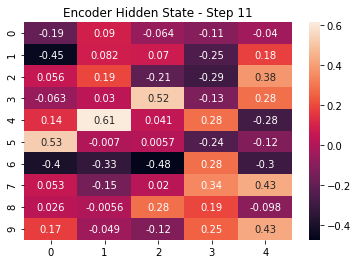

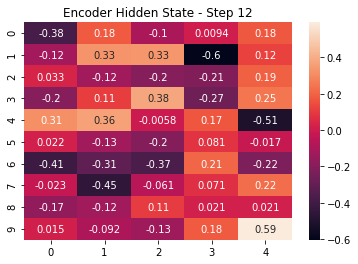

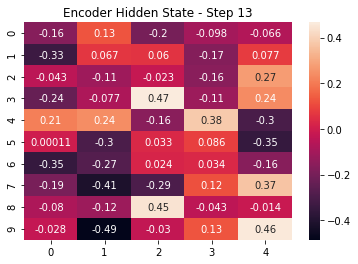

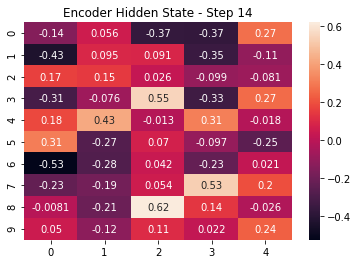

In [189]:
for step_ix in range(len(states_collector['encoder'])):
    state = states_collector['encoder'][step_ix]
    hidden_state = state['hidden']
    plt.show(sns.heatmap(hidden_state.cpu().detach().numpy().reshape(-1, 5), 
                         annot=True).set(title=f"Encoder Hidden State - Step {step_ix+1}"))

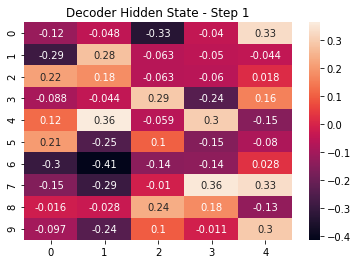

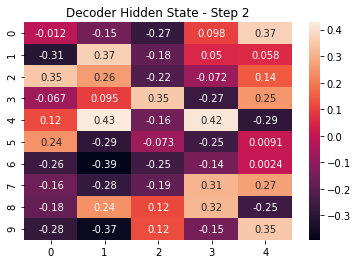

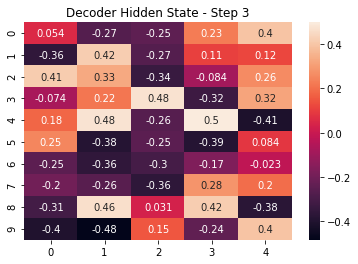

In [187]:
for step_ix in range(len(states_collector['decoder'])):
    state = states_collector['decoder'][step_ix]
    hidden_state = state['hidden']
    plt.show(sns.heatmap(hidden_state.cpu().detach().numpy().reshape(-1, 5), 
                         annot=True).set(title=f"Decoder Hidden State - Step {step_ix+1}"))

## Plotting Confusion matrix the data

In [210]:
import spacy
nlp = spacy.load('en')

path='/content/END2/weights/best_model.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)


def classify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    indexed = [tokenizer[t] for t in tokenized]        
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)   

    tensor = tensor.unsqueeze(1).T  
    length_tensor = torch.LongTensor(length)


    prediction = model(tensor, length_tensor)
    pred = torch.argmax(prediction.squeeze(0), 1) 
    
    return categories[pred.item()]

In [211]:
df['predictions'] = df['tweets_clean'].apply(classify_tweet)

In [214]:
df['predictions'].value_counts()

Negative    1351
Name: predictions, dtype: int64

In [237]:
from sklearn.metrics import confusion_matrix
import numpy as np


def plot_confusion_matrix(y_true, y_pred, classes=['Negative','Positive', 'Neutral'], cmap=plt.cm.YlOrBr):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa8d4ed310>)

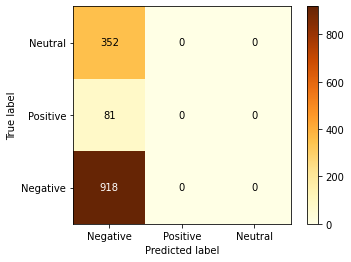

In [238]:
categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
plot_confusion_matrix(df['labels'].apply(lambda x: categories[x]).values.tolist(), df['predictions'].values.tolist())